In [1]:
import pandas
import numpy
from matplotlib import pyplot
import os
import ROOT

Welcome to JupyROOT 6.24/06


In [2]:
times = {"taskid":[],"mean":[],"meanerr":[],"throughput_MB_s":[]}
maindir = "20211119-8corespernode-taskset8152431-200x"
timedirs = [timedir for timedir in os.listdir(maindir) if timedir.startswith("timeresults")]

dfs = []
for timedir in timedirs:
    nodes = int(timedir.split("_")[2].replace("nodes",""))
    corespernode = int(timedir.split("_")[3].replace("corespernode",""))
    chunks = nodes*corespernode
    for f in os.listdir(os.path.join(maindir, timedir)):
        df = pandas.read_csv(os.path.join(maindir, timedir, f), header=None, names=["taskruntime","taskreadtime","readthroughput","readpayload"], skiprows=1)
        taskid = int(f.split("_")[1].replace("task",""))
        df["taskid"] = int(taskid)
        df["nodes"] = int(nodes)
        df["chunks"] = int(chunks)
        dfs.append(df)

df = pandas.concat(dfs).sort_values(by="nodes").reset_index(drop=True)
df

,taskruntime,taskreadtime,readthroughput,readpayload,taskid,nodes,chunks
0,50.800,9595941424,2942,28235189400,6,1,8
1,47.700,7294382405,3870,28235189400,1,1,8
2,49.432,7277092217,3880,28235189400,1,1,8
3,45.992,9850006900,2866,28235189400,1,1,8
4,48.457,7390720303,3820,28235189400,1,1,8
...,...,...,...,...,...,...,...
1507,7.617,2245346038,2095,4705864944,17,6,48
1508,8.296,2282685950,2061,4705864812,31,6,48
1509,8.668,2226845124,2113,4705864812,31,6,48
1510,8.706,2165461052,2173,4705864812,7,6,48


In [3]:
meantaskthroughput = df.groupby(["chunks"]).mean()
meantaskthroughput = meantaskthroughput.reset_index().sort_values("chunks").reset_index(drop=True)
meantaskthroughput


,chunks,taskruntime,taskreadtime,readthroughput,readpayload,taskid,nodes
0,8,48.535319,8.207412e+09,3498.930556,2.823519e+10,3.5,1.0
1,16,24.821444,4.673404e+09,3065.694444,1.411759e+10,7.5,2.0
2,24,16.408662,3.187770e+09,2994.236111,9.411730e+09,11.5,3.0
3,32,12.336240,2.496450e+09,2856.986111,7.058797e+09,15.5,4.0
4,40,10.133578,2.301196e+09,2473.594444,5.647038e+09,19.5,5.0
5,48,8.357171,2.183032e+09,2166.138889,4.705865e+09,23.5,6.0


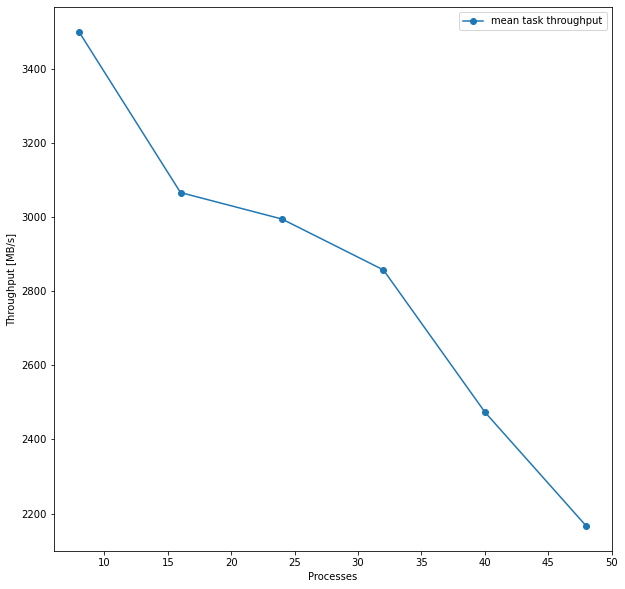

In [4]:
pyplot.figure(figsize=[10,10])
pyplot.plot(meantaskthroughput["chunks"], meantaskthroughput["readthroughput"], label="mean task throughput", marker="o")
pyplot.xlabel("Processes")
pyplot.ylabel("Throughput [MB/s]")
pyplot.legend()

In [5]:
sumthroughput = df.groupby(["chunks","nodes","taskid"]).mean()
sumthroughput = sumthroughput.reset_index().groupby(["chunks","nodes"]).sum()
sumthroughput = sumthroughput.reset_index()
sumthroughput["totalthroughput"] = sumthroughput["readthroughput"] / 1024
sumthroughput["speedup"] = sumthroughput["readthroughput"] / sumthroughput["readthroughput"][0] 
sumthroughput

,chunks,nodes,taskid,taskruntime,taskreadtime,readthroughput,readpayload,totalthroughput,speedup
0,8,1,28,388.282556,6.565930e+10,27991.444444,2.258815e+11,27.335395,1.000000
1,16,2,120,397.143111,7.477447e+10,49051.111111,2.258815e+11,47.901476,1.752361
2,24,3,276,393.807889,7.650649e+10,71861.666667,2.258815e+11,70.177409,2.567273
3,32,4,496,394.759667,7.988640e+10,91423.555556,2.258815e+11,89.280816,3.266125
4,40,5,780,405.343111,9.204785e+10,98943.777778,2.258815e+11,96.624783,3.534786
5,48,6,1128,401.144222,1.047855e+11,103974.666667,2.258815e+11,101.537760,3.714516


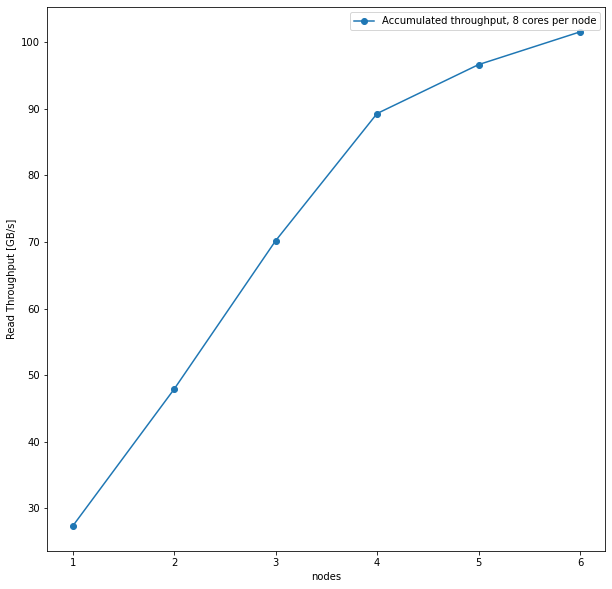

In [6]:
pyplot.figure(figsize=[10,10])
pyplot.plot(sumthroughput["nodes"], sumthroughput["totalthroughput"], label="Accumulated throughput, 8 cores per node", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Read Throughput [GB/s]")
pyplot.legend()

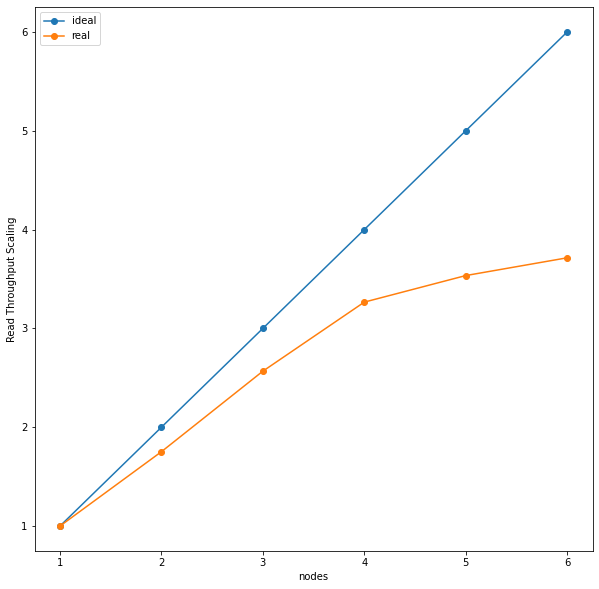

In [7]:
pyplot.figure(figsize=[10,10])
pyplot.plot(sumthroughput["nodes"], sumthroughput["nodes"], label="ideal", marker="o")
pyplot.plot(sumthroughput["nodes"], sumthroughput["speedup"], label="real", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Read Throughput Scaling")
pyplot.legend()

# Python timer

In [8]:
times = {"nodes":[],"meanruntime":[], "err":[], "throughput_GB_s":[]}
timedir = "20211119-8corespernode-taskset8152431-200x/appruntimes"
datasetsize = 157400503680
readpercent = 0.7949011466389114
readsize = 225881515200 # taken from the RNTuple metrics above

for f in os.listdir(timedir):
    array = numpy.genfromtxt(os.path.join(timedir, f), skip_header=2)
    nodes = f.split("_")[5].replace("nodes","")
    time_mean = numpy.mean(array)
    times["nodes"].append(int(nodes))
    times["meanruntime"].append(round(time_mean, 2))
    times["err"].append(round(numpy.std(array)/numpy.sqrt(len(array)), 2))
    times["throughput_GB_s"].append(readsize/time_mean/pow(10,9))
    
timesdf = pandas.DataFrame(times)
timesdf = timesdf.sort_values(by="nodes").reset_index(drop=True).copy()
throughput_1node = timesdf["throughput_GB_s"][0]
time_1node = timesdf["meanruntime"][0]
timesdf["runtimespeedup"] = time_1node / timesdf["meanruntime"]
timesdf["throughputspeedup"] = timesdf["throughput_GB_s"] / throughput_1node
timesdf

,nodes,meanruntime,err,throughput_GB_s,runtimespeedup,throughputspeedup
0,1,50.53,0.41,4.469958,1.000000,1.000000
1,2,26.91,0.24,8.393494,1.877741,1.877757
2,3,17.80,0.21,12.691220,2.838764,2.839226
3,4,13.74,0.26,16.437460,3.677584,3.677318
4,5,11.30,0.12,19.992390,4.471681,4.472612
5,6,9.36,0.13,24.132641,5.398504,5.398851


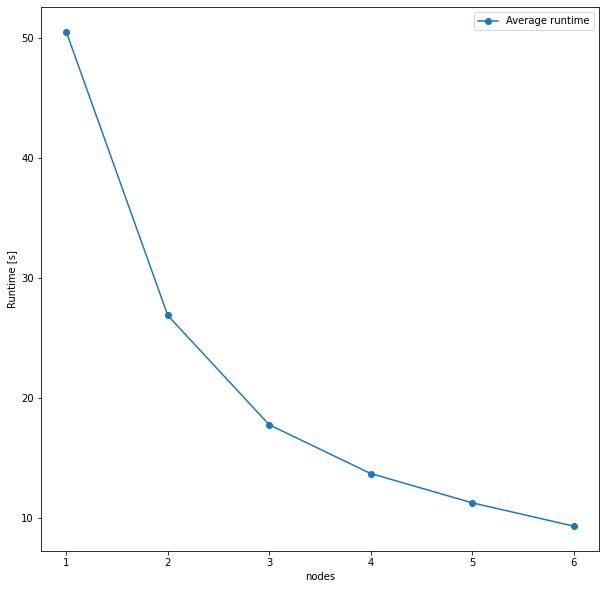

In [9]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["nodes"], timesdf["meanruntime"], label="Average runtime", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Runtime [s]")
pyplot.legend()

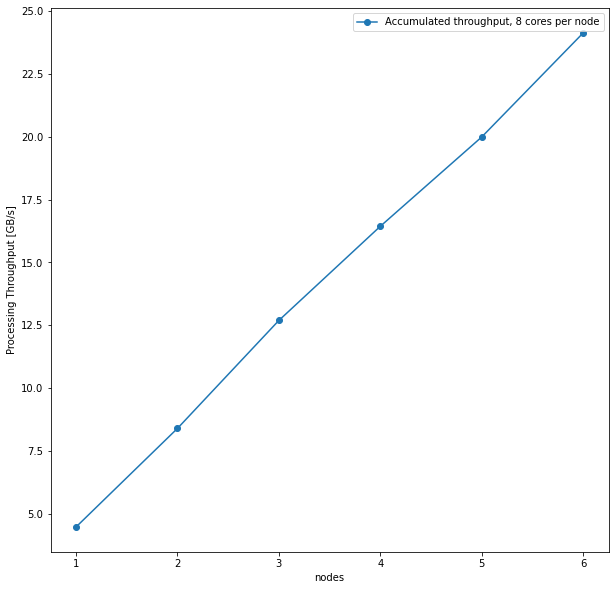

In [10]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["nodes"], timesdf["throughput_GB_s"], label="Accumulated throughput, 8 cores per node", marker="o")
pyplot.xlabel("nodes")
pyplot.ylabel("Processing Throughput [GB/s]")
pyplot.legend()

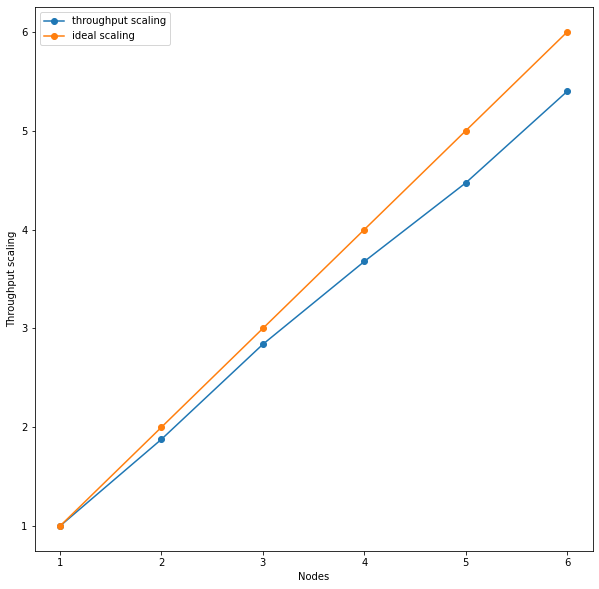

In [11]:
pyplot.figure(figsize=[10,10])
pyplot.plot(timesdf["nodes"], timesdf["throughputspeedup"], label="throughput scaling", marker="o")
pyplot.plot(timesdf["nodes"], timesdf["nodes"], label="ideal scaling", marker="o")
pyplot.xticks(timesdf["nodes"])
pyplot.yticks(timesdf["nodes"])
pyplot.xlabel("Nodes")
pyplot.ylabel("Throughput scaling")
pyplot.legend()

# TGraph

Info in <TCanvas::Print>: png file distrdf_lhcb_multinode_processingthroughput.png has been created


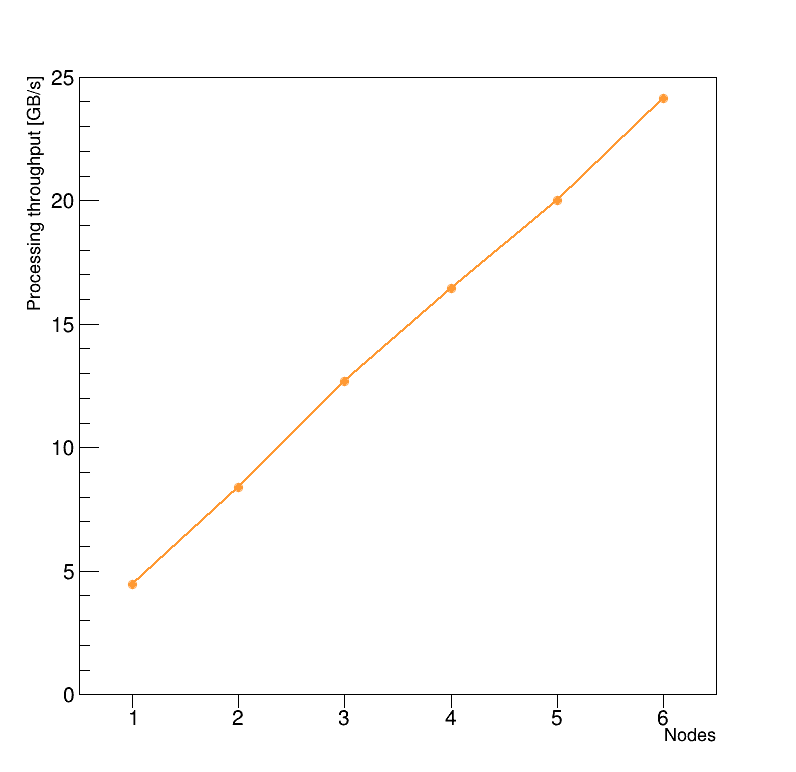

In [12]:
runtimegraph = ROOT.TGraph(len(timesdf["nodes"]), numpy.array(timesdf["nodes"], dtype=float), numpy.array(timesdf["throughput_GB_s"], dtype=float))

width = 800
height = 800
d = ROOT.TCanvas("d", "", width, height)

runtimegraph.SetTitle("")

runtimegraph.GetXaxis().SetTitle("Nodes")
runtimegraph.GetXaxis().SetTitleSize(0.025)
runtimegraph.GetXaxis().SetTitleOffset(1.3)
runtimegraph.GetXaxis().SetLabelSize(0)
runtimegraph.GetXaxis().SetTickLength(0)

runtimegraph.GetYaxis().SetTitle("Processing throughput [GB/s]")
runtimegraph.GetYaxis().SetLabelSize(0.03)
runtimegraph.GetYaxis().SetTitleSize(0.025)
runtimegraph.GetYaxis().SetRangeUser(0, 25)

runtimegraph.SetMarkerStyle(20)
runtimegraph.SetMarkerSize(1)
runtimegraph.SetMarkerColor(ROOT.kOrange+1)

runtimegraph.SetLineStyle(ROOT.kSolid)
# Line color also decides error bar color somehow
runtimegraph.SetLineColorAlpha(ROOT.kOrange+1,1)
runtimegraph.SetLineWidth(2)
runtimegraph.Draw("APL")

ymin = runtimegraph.GetHistogram().GetMinimum()
ymax = runtimegraph.GetHistogram().GetMaximum()

dy = ymax - ymin
labels = []
ticks = []

for i in range(len(timesdf["nodes"])):
    x = runtimegraph.GetPointX(i)
    t = ROOT.TLatex(x, ymin - 0.05 * dy, str(int(x)))
    t.SetTextSize(0.03)
    t.SetTextFont(42)
    t.SetTextAlign(21)
    t.Draw()
    labels.append(t)
    l = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    l.Draw()
    ticks.append(l)
    
d.Draw()
d.SaveAs("distrdf_lhcb_multinode_processingthroughput.png")

Info in <TCanvas::Print>: png file distrdf_lhcb_multinode_processingthroughputspeedup.png has been created


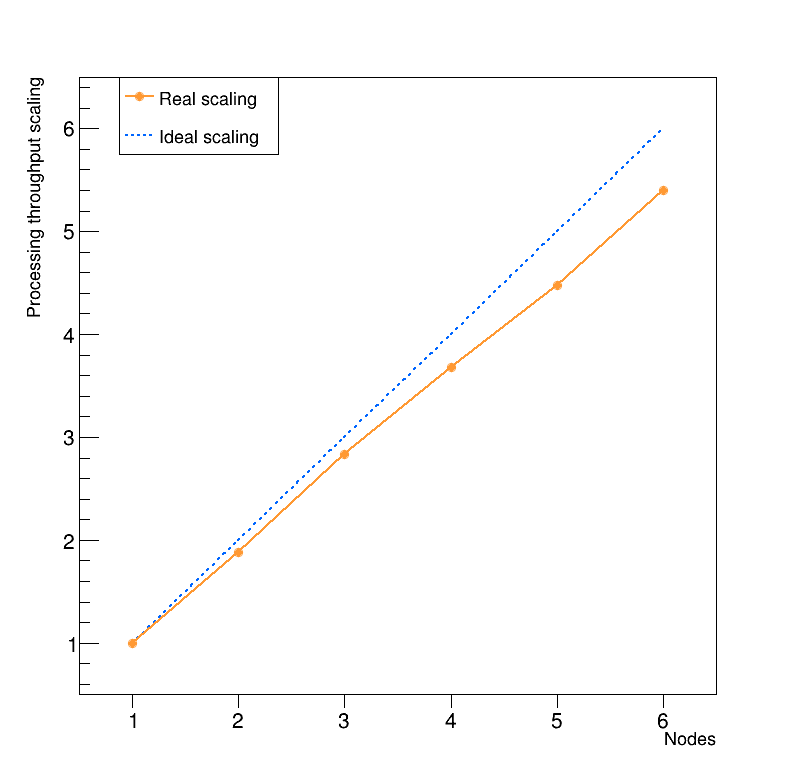

In [13]:
speedupgraph = ROOT.TGraph(len(timesdf["nodes"]), numpy.array(timesdf["nodes"], dtype=float), numpy.array(timesdf["throughputspeedup"], dtype=float))
idealspeedupgraph = ROOT.TGraph(len(timesdf["nodes"]), numpy.array(timesdf["nodes"], dtype=float), numpy.array(timesdf["nodes"], dtype=float))

width = 800
height = 800
c = ROOT.TCanvas("c", "", width, height)

idealspeedupgraph.SetTitle("")

idealspeedupgraph.GetXaxis().SetTitle("Nodes")
idealspeedupgraph.GetXaxis().SetTitleSize(0.025)
idealspeedupgraph.GetXaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetXaxis().SetLabelSize(0)
idealspeedupgraph.GetXaxis().SetTickLength(0)
idealspeedupgraph.GetYaxis().SetTitle("Processing throughput scaling")

idealspeedupgraph.GetYaxis().SetTitleSize(0.025)
idealspeedupgraph.GetYaxis().SetTitleOffset(1.4)
#idealspeedupgraph.GetYaxis().SetRangeUser(0, 6)
idealspeedupgraph.GetYaxis().SetLabelSize(0.03)

idealspeedupgraph.SetMarkerColor(ROOT.kAzure-3)
idealspeedupgraph.SetMarkerSize(1)
idealspeedupgraph.SetMarkerStyle(20)
idealspeedupgraph.SetLineStyle(ROOT.kDashed)
idealspeedupgraph.SetLineColorAlpha(ROOT.kAzure-3,1)
idealspeedupgraph.SetLineWidth(2)
idealspeedupgraph.Draw("AL")

ymin = idealspeedupgraph.GetHistogram().GetMinimum()
ymax = idealspeedupgraph.GetHistogram().GetMaximum()

dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(timesdf["nodes"])):
    x = idealspeedupgraph.GetPointX(i)
    y = idealspeedupgraph.GetPointY(i)

    xt = ROOT.TLatex(x, 0.17, str(int(x)))
    xt.SetTextSize(0.03)
    xt.SetTextFont(42)
    xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    xl.Draw()
    xticks.append(xl)

speedupgraph.SetMarkerStyle(20)
speedupgraph.SetMarkerSize(1)
speedupgraph.SetMarkerColor(ROOT.kOrange+1)


speedupgraph.SetLineColorAlpha(ROOT.kOrange+1,1)
speedupgraph.SetLineWidth(2)

speedupgraph.Draw("SAME PL")

legend = ROOT.TLegend(0.15,0.8,0.35,0.9)
legend.AddEntry(speedupgraph, "Real scaling")
legend.AddEntry(idealspeedupgraph, "Ideal scaling", "L")
legend.Draw()
ROOT.gStyle.SetLegendTextSize(0.025)
c.Draw()
c.SaveAs("distrdf_lhcb_multinode_processingthroughputspeedup.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: c
Info in <TCanvas::Print>: png file distrdf_lhcb_multinode_processingthroughputspeedup.png has been created


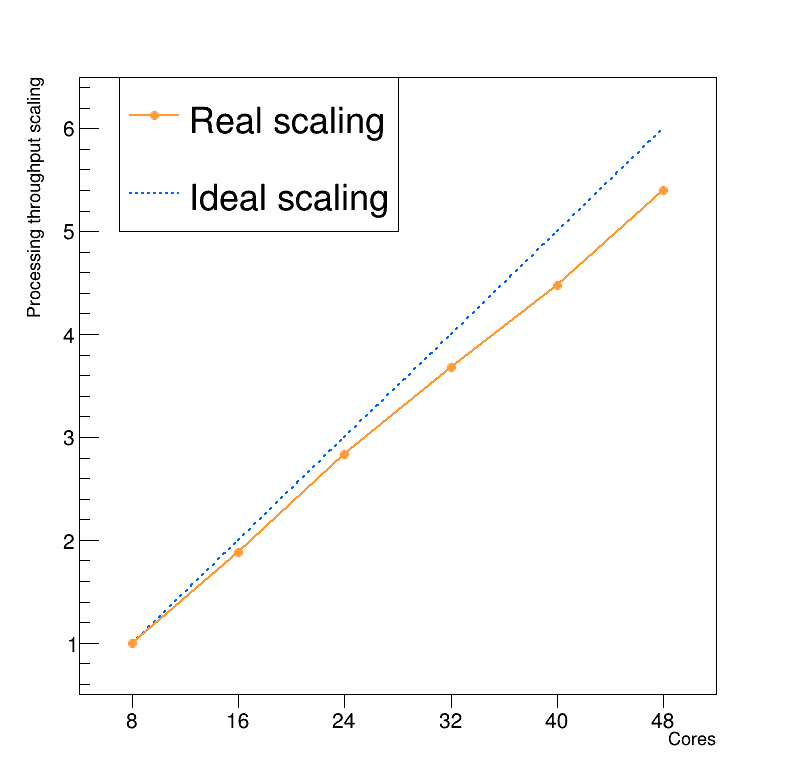

In [21]:
speedupgraph = ROOT.TGraph(len(timesdf["nodes"]), numpy.array(timesdf["nodes"], dtype=float), numpy.array(timesdf["throughputspeedup"], dtype=float))
idealspeedupgraph = ROOT.TGraph(len(timesdf["nodes"]), numpy.array(timesdf["nodes"], dtype=float), numpy.array(timesdf["nodes"], dtype=float))

width = 800
height = 800
c = ROOT.TCanvas("c", "", width, height)

idealspeedupgraph.SetTitle("")

idealspeedupgraph.GetXaxis().SetTitle("Cores")
idealspeedupgraph.GetXaxis().SetTitleSize(0.025)
idealspeedupgraph.GetXaxis().SetTitleOffset(1.4)
idealspeedupgraph.GetXaxis().SetLabelSize(0)
idealspeedupgraph.GetXaxis().SetTickLength(0)
idealspeedupgraph.GetYaxis().SetTitle("Processing throughput scaling")

idealspeedupgraph.GetYaxis().SetTitleSize(0.025)
idealspeedupgraph.GetYaxis().SetTitleOffset(1.4)
#idealspeedupgraph.GetYaxis().SetRangeUser(0, 6)
idealspeedupgraph.GetYaxis().SetLabelSize(0.03)

idealspeedupgraph.SetMarkerColor(ROOT.kAzure-3)
idealspeedupgraph.SetMarkerSize(1)
idealspeedupgraph.SetMarkerStyle(20)
idealspeedupgraph.SetLineStyle(ROOT.kDashed)
idealspeedupgraph.SetLineColorAlpha(ROOT.kAzure-3,1)
idealspeedupgraph.SetLineWidth(2)
idealspeedupgraph.Draw("AL")

ymin = idealspeedupgraph.GetHistogram().GetMinimum()
ymax = idealspeedupgraph.GetHistogram().GetMaximum()

dy = ymax - ymin
xlabels = []
xticks = []
#ylabels = []
#yticks = []

for i in range(len(timesdf["nodes"])):
    x = idealspeedupgraph.GetPointX(i)
    y = idealspeedupgraph.GetPointY(i)

    xt = ROOT.TLatex(x, 0.17, str(int(x)*8))
    xt.SetTextSize(0.03)
    xt.SetTextFont(42)
    xt.SetTextAlign(21)
    xt.Draw()
    xlabels.append(xt)

    xl = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    xl.Draw()
    xticks.append(xl)

speedupgraph.SetMarkerStyle(20)
speedupgraph.SetMarkerSize(1)
speedupgraph.SetMarkerColor(ROOT.kOrange+1)


speedupgraph.SetLineColorAlpha(ROOT.kOrange+1,1)
speedupgraph.SetLineWidth(2)

speedupgraph.Draw("SAME PL")

legend = ROOT.TLegend(0.15,0.7,0.5,0.9)
legend.AddEntry(speedupgraph, "Real scaling")
legend.AddEntry(idealspeedupgraph, "Ideal scaling", "L")
legend.Draw()
ROOT.gStyle.SetLegendTextSize(0.05)
c.Draw()
c.SaveAs("distrdf_lhcb_multinode_processingthroughputspeedup.png")

Warning in <TCanvas::Constructor>: Deleting canvas with same name: d
Info in <TCanvas::Print>: png file distrdf_lhcb_multinode_processingthroughput.png has been created


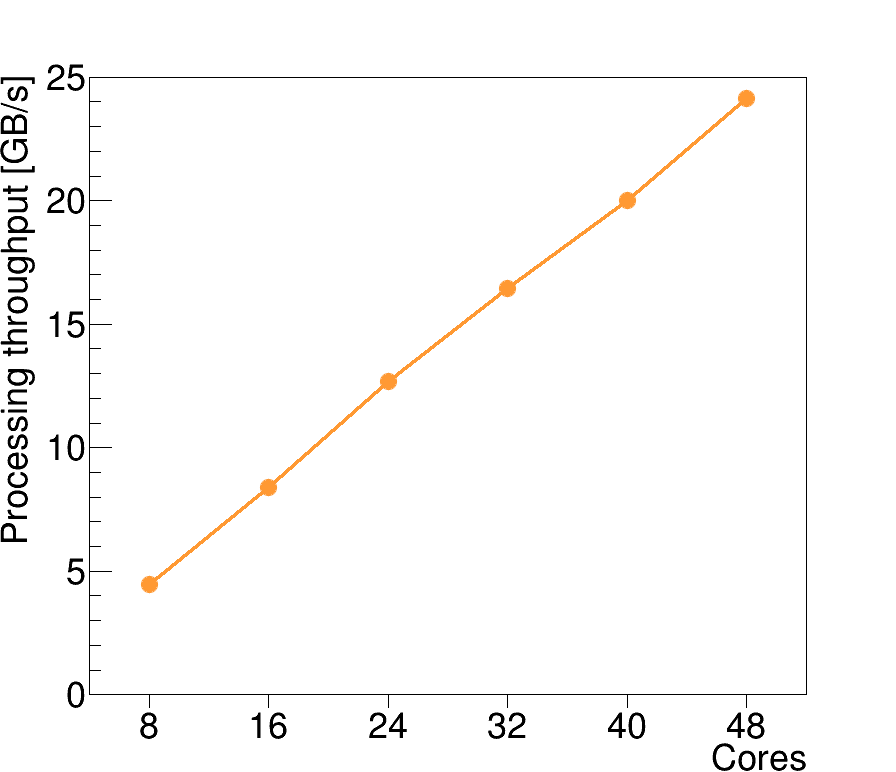

In [36]:
runtimegraph = ROOT.TGraph(len(timesdf["nodes"]), numpy.array(timesdf["nodes"], dtype=float), numpy.array(timesdf["throughput_GB_s"], dtype=float))

width = 900
height = 800
d = ROOT.TCanvas("d", "", width, height)

runtimegraph.SetTitle("")

runtimegraph.GetXaxis().SetTitle("Cores")
runtimegraph.GetXaxis().SetTitleSize(0.05)
runtimegraph.GetXaxis().SetTitleOffset(1)
runtimegraph.GetXaxis().SetLabelSize(0)
runtimegraph.GetXaxis().SetTickLength(0)

runtimegraph.GetYaxis().SetTitle("Processing throughput [GB/s]")
runtimegraph.GetYaxis().SetLabelSize(0.05)
runtimegraph.GetYaxis().SetTitleSize(0.05)
runtimegraph.GetYaxis().SetTitleOffset(1)
runtimegraph.GetYaxis().SetRangeUser(0, 25)

runtimegraph.SetMarkerStyle(20)
runtimegraph.SetMarkerSize(2)
runtimegraph.SetMarkerColor(ROOT.kOrange+1)

runtimegraph.SetLineStyle(ROOT.kSolid)
# Line color also decides error bar color somehow
runtimegraph.SetLineColorAlpha(ROOT.kOrange+1,1)
runtimegraph.SetLineWidth(3)
runtimegraph.Draw("APL")

ymin = runtimegraph.GetHistogram().GetMinimum()
ymax = runtimegraph.GetHistogram().GetMaximum()

dy = ymax - ymin
labels = []
ticks = []

for i in range(len(timesdf["nodes"])):
    x = runtimegraph.GetPointX(i)
    t = ROOT.TLatex(x, ymin - 0.07 * dy, str(int(x)*8))
    t.SetTextSize(0.05)
    t.SetTextFont(42)
    t.SetTextAlign(21)
    t.Draw()
    labels.append(t)
    l = ROOT.TLine(x, ymin, x,ymin-0.02*dy)
    l.Draw()
    ticks.append(l)
    
d.Draw()
d.SaveAs("distrdf_lhcb_multinode_processingthroughput.png")